In [6]:
import logging
from functools import partial
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glassplitter import Tokenizer
from rich.logging import RichHandler
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import make_pipeline

from arxiv_dataset import fetch_arxiv_sample
from pdf_extract import custom_analyzer
from utils import execution_time

## Logger

logging.basicConfig(
    level=logging.INFO,
    format="%(message)s",
    handlers=[RichHandler(log_time_format="%X")],
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

## Data, Metadata

arxiv_sample = fetch_arxiv_sample(Path("sample/50_ids.txt"))
metadata = pd.DataFrame({
    "arxiv_id": arxiv_sample.ids,
    "title": arxiv_sample.titles,
    "date": arxiv_sample.dates,
})
corpus = arxiv_sample.data

## Tokenizer

tokenizer = Tokenizer(lang="en", clean=True, doc_type="pdf")

## Preprocessor

extra_stop_words = list("().,abcdefghijklmnopqrstuvvwxyz")
analyzer = custom_analyzer(tokenizer, filter_tokens=extra_stop_words)
data = []
with execution_time() as t:
    for i, pdf in enumerate(corpus):
        logger.debug("Analyzing pdf %s", arxiv_sample.ids[i])
        try:
            data.append(analyzer(pdf))
        except:
            logger.exception(
            "An error occured while handling arxiv_id %s", arxiv_sample.ids[i]
        )
            raise
logger.info(f"Tokenized {len(data)=} PDFs in {t()}")

## Tfidf Vectorizer

tfidf_vectorizer = make_pipeline(
    CountVectorizer(
        # max_df=0.5, # Percentage of docs
        # min_df=3, # Absolute number of docs to contain feature (word)
        #
        # vectorizer expects documents to be of str, so some trickery is required here
        preprocessor=partial(map, str.lower),
        tokenizer=lambda x: x, # documents are tokenized already
        #
        max_features=5000,
        # stop_words and ngram_range are not used when analyzer in use
        stop_words="english",
        # ngram_range=(1, 2),
    ),
    TfidfTransformer(sublinear_tf=True),
)
with execution_time() as t:
    data_vectors = tfidf_vectorizer.fit_transform(data)
logger.info(f"Vectorization done in {t()}")


14:52:57 INFO     Tokenized len(data)=50 PDFs in 0:01:26.500854                                    ]8;id=323027;file:///tmp/ipykernel_85185/3550077866.py\3550077866.py]8;;\:]8;id=901192;file:///tmp/ipykernel_85185/3550077866.py#61\61]8;;\

/home/bmo/anaconda3/envs/document-clustering/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/bmo/anaconda3/envs/document-clustering/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


         INFO     Vectorization done in 0:00:00.296104                                             ]8;id=118312;file:///tmp/ipykernel_85185/3550077866.py\3550077866.py]8;;\:]8;id=891819;file:///tmp/ipykernel_85185/3550077866.py#83\83]8;;\

In [7]:
## Dimensionality reduction using truncated SVD (aka LSA)

svd = TruncatedSVD()
data_representation_2D = svd.fit_transform(data_vectors)

14:53:21 INFO     For n_clusters=2, the average silhouette_score is : 0.024306229588917528         ]8;id=387360;file:///tmp/ipykernel_85185/2422111684.py\2422111684.py]8;;\:]8;id=740258;file:///tmp/ipykernel_85185/2422111684.py#27\27]8;;\

         INFO     For n_clusters=3, the average silhouette_score is : 0.028269226466018815         ]8;id=379009;file:///tmp/ipykernel_85185/2422111684.py\2422111684.py]8;;\:]8;id=470648;file:///tmp/ipykernel_85185/2422111684.py#27\27]8;;\

         INFO     For n_clusters=4, the average silhouette_score is : 0.019917579391868154         ]8;id=14787;file:///tmp/ipykernel_85185/2422111684.py\2422111684.py]8;;\:]8;id=468317;file:///tmp/ipykernel_85185/2422111684.py#27\27]8;;\

         INFO     For n_clusters=5, the average silhouette_score is : 0.013411574868138553         ]8;id=178376;file:///tmp/ipykernel_85185/2422111684.py\2422111684.py]8;;\:]8;id=21029;file:///tmp/ipykernel_85185/2422111684.py#27\27]8;;\

         INFO     For n_clusters=6, the average silhouette_score is : 0.018316046780787697         ]8;id=214410;file:///tmp/ipykernel_85185/2422111684.py\2422111684.py]8;;\:]8;id=967540;file:///tmp/ipykernel_85185/2422111684.py#27\27]8;;\

         INFO     For n_clusters=7, the average silhouette_score is : 0.01289433014372746          ]8;id=726559;file:///tmp/ipykernel_85185/2422111684.py\2422111684.py]8;;\:]8;id=434867;file:///tmp/ipykernel_85185/2422111684.py#27\27]8;;\

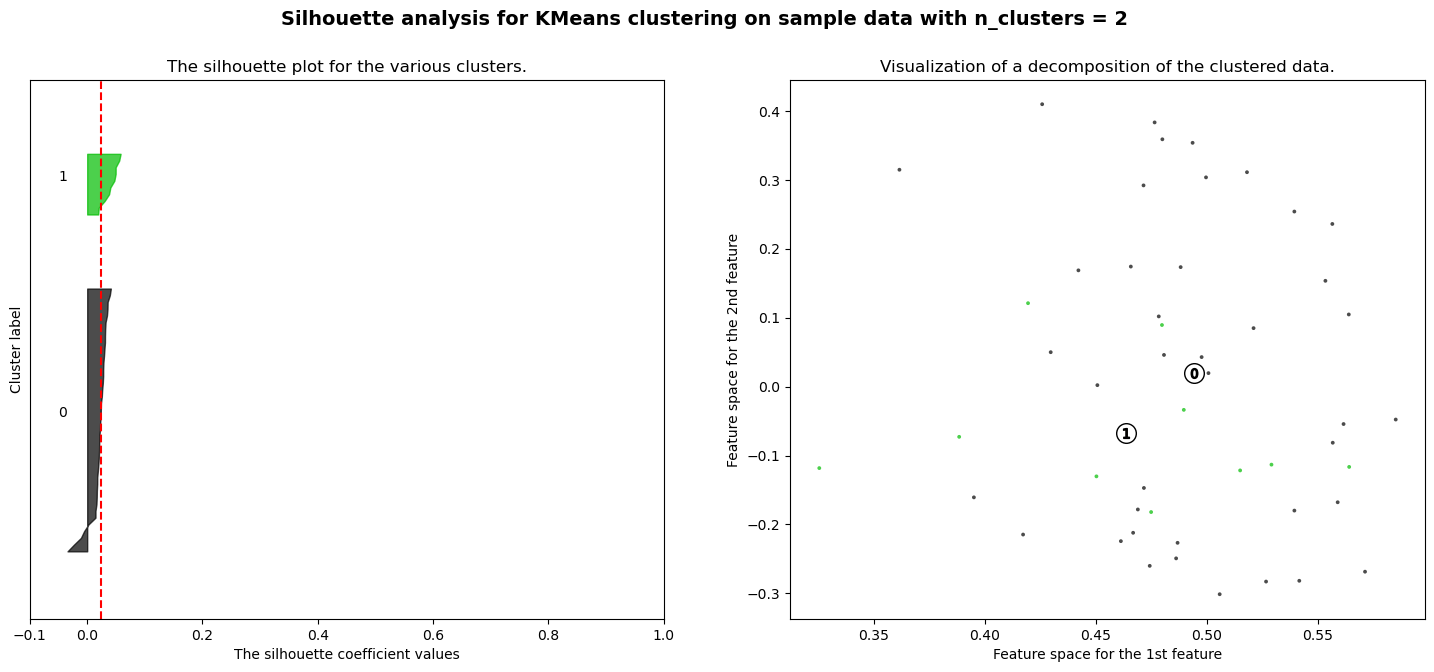

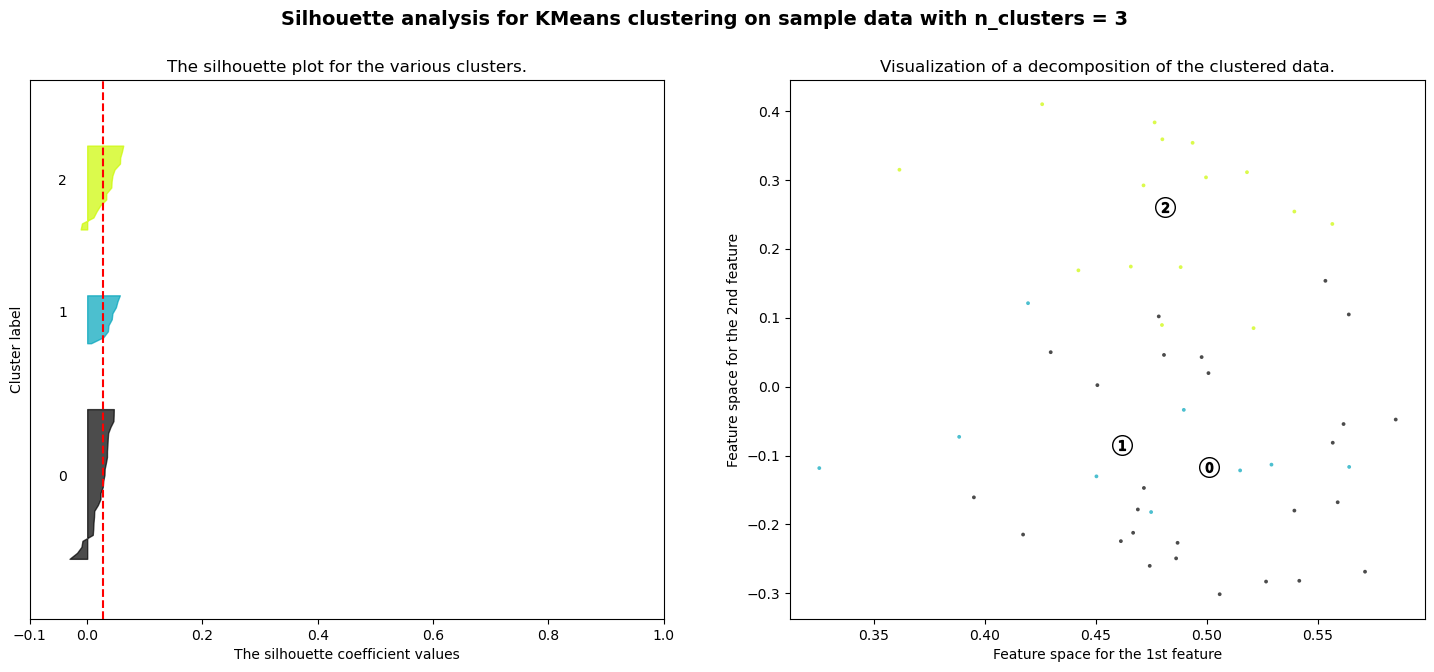

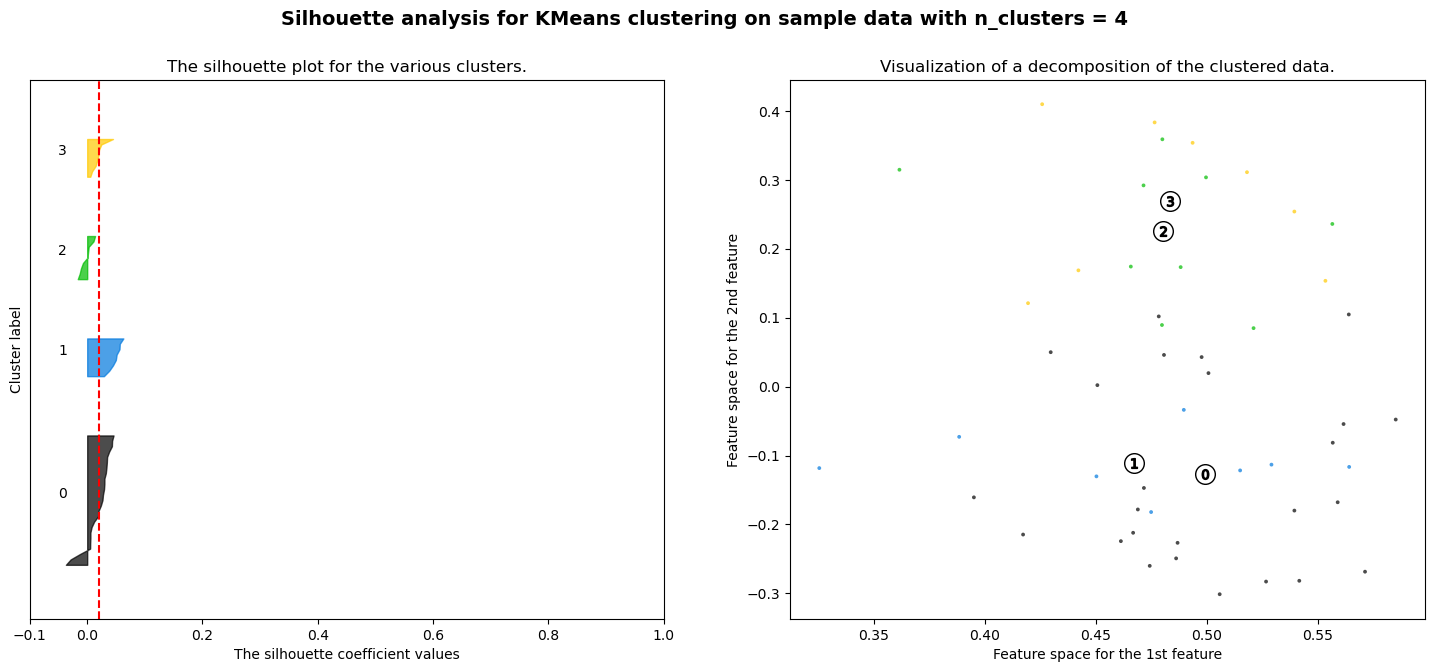

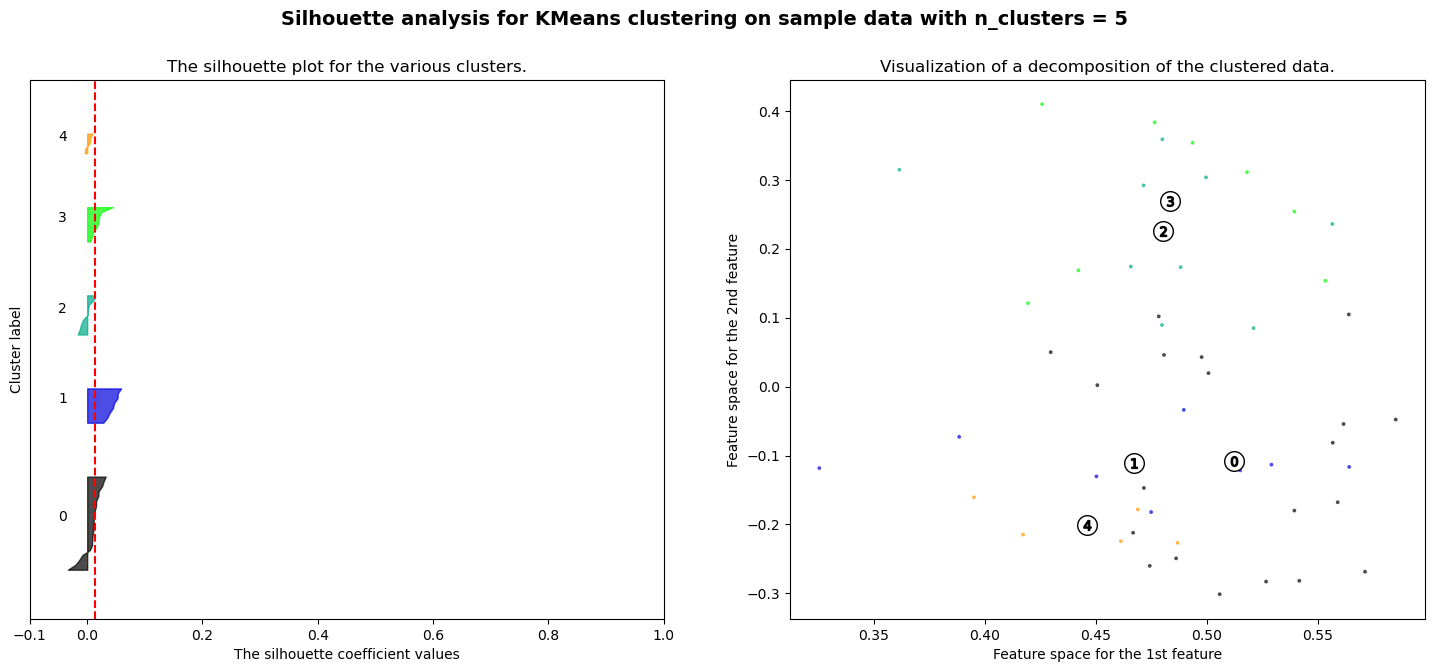

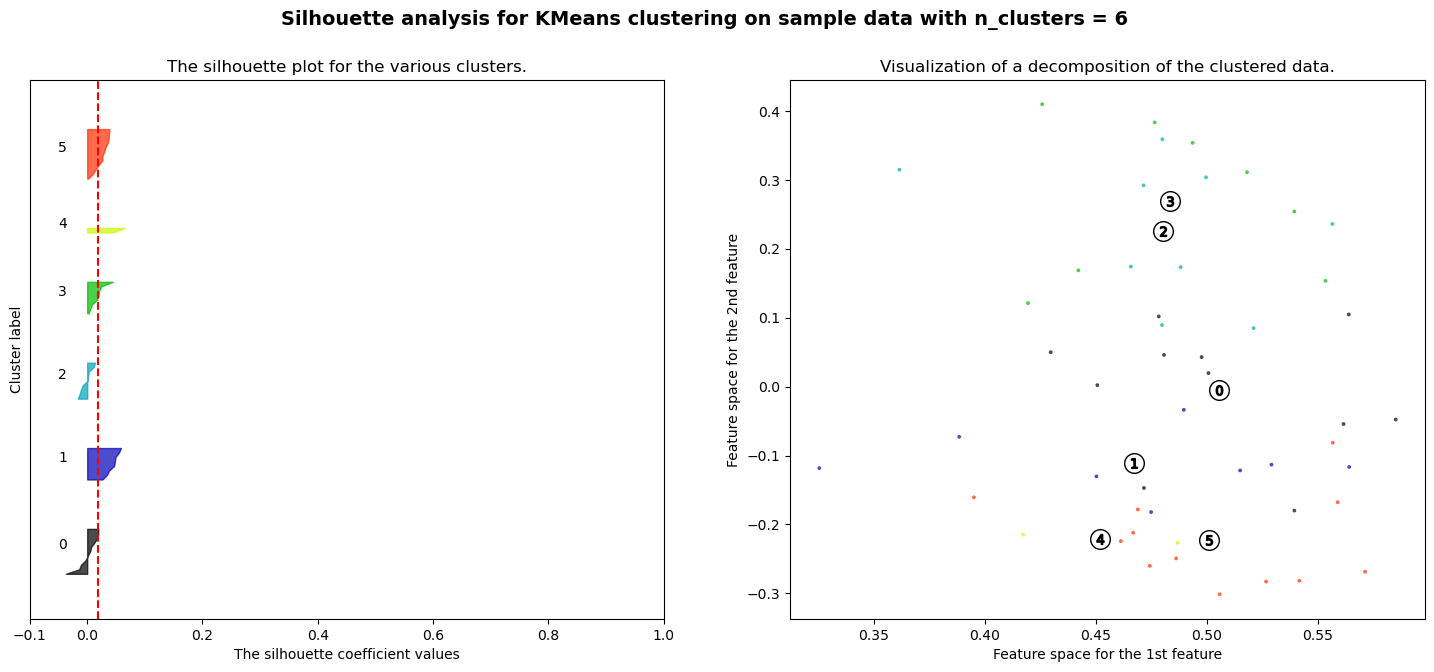

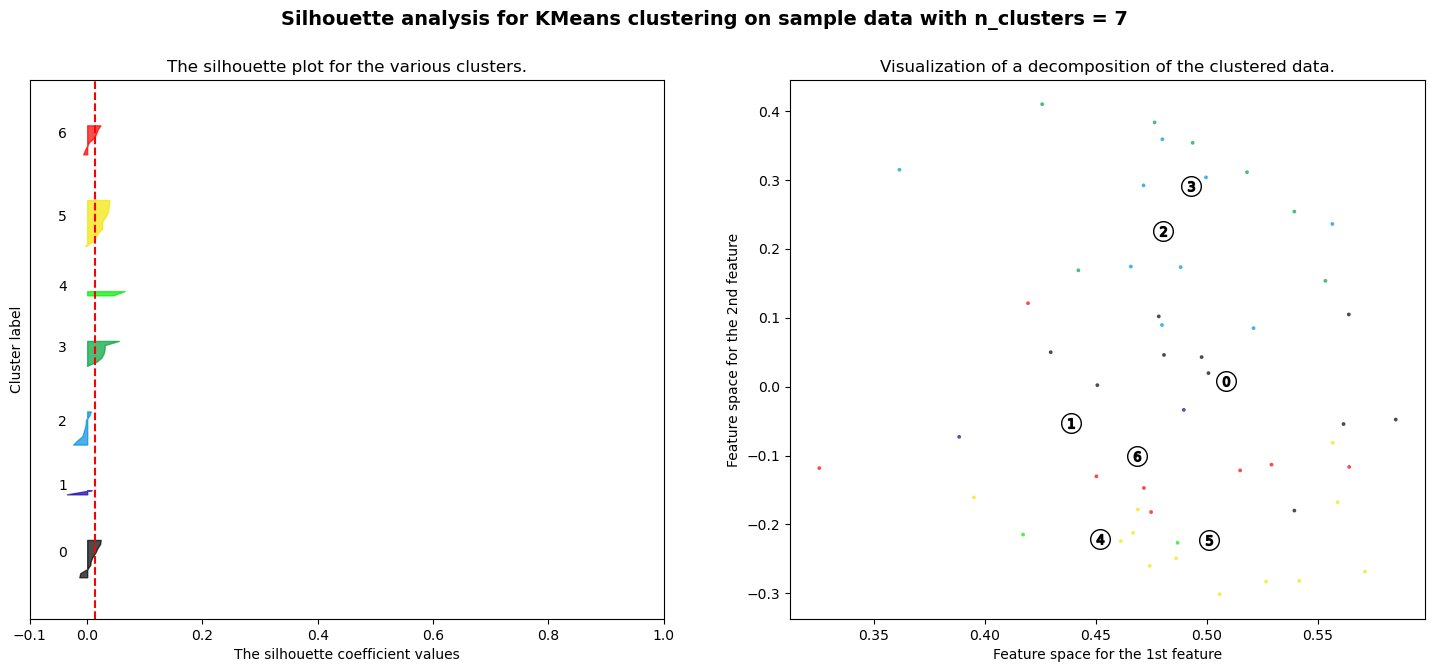

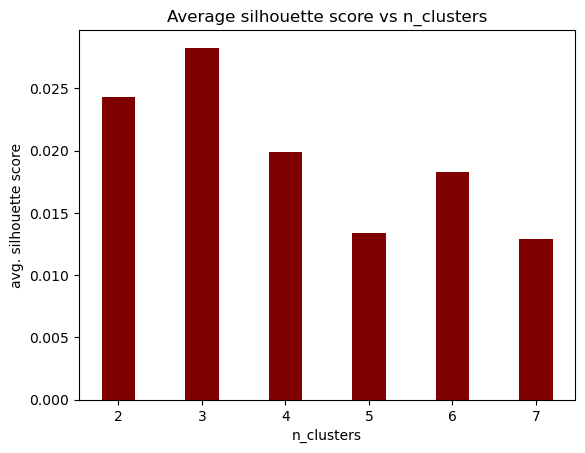

In [8]:
## Silhouette Analysis

range_n_clusters = [2, 3, 4, 5, 6, 7]
silhouette_scores = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, data_vectors.shape[0] + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    with execution_time() as t:
        cluster_labels = clusterer.fit_predict(data_vectors)
    logger.debug(f"Clustering for {n_clusters=} done in {t()}")

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_vectors, cluster_labels)
    logger.info(
        f"For {n_clusters=}, the average silhouette_score is : {silhouette_avg}"
    )
    silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_vectors, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        data_representation_2D[:, 0],
        data_representation_2D[:, 1],
        marker=".",
        s=30,
        lw=0,
        alpha=0.7,
        c=colors,
        edgecolor="k",
    )

    # Labeling the clusters
    centers = svd.transform(clusterer.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of a decomposition of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.figure()
fig.set_size_inches(18, 7)
plt.bar(range_n_clusters, silhouette_scores, color="maroon", width=0.4)

plt.xlabel("n_clusters")
plt.ylabel("avg. silhouette score")
plt.title("Average silhouette score vs n_clusters")

plt.show()